# Turn 50,000 diffraction images from a dynamic crack tip scan into an animated gif showing a time-dependent crystallinity map

<h3>Setup:</h3>
<ul>
    <li>
        Rubber sample with crack mounted on dynamic tensile testing machine cycling at 1 Hz (rubber sample ca. 10mm x 2mm x 1mm, crack length 0.5mm)
    </li>
    <li>
        Microfocus X-ray beam, beam size much smaller scan step size to reduce spatial blurring due to finite exposure time
    </li>
    <li>
   Diffraction data recorded at 50 Hz using Pilatus 300K detector, cbf format, total 50,000 images, images have time stamps, scan position is encoded in filenames
         </li>
    <li>
   Area scan across the sample
         </li>
    <li>
   Strain is not being recorded because tensile machine did not have this option. To overcome this problem, two metal fingers are mounted on the tensile machine that produce shadows on the X-ray detector, from the position of which the strain (nominal strain, elongation) can be computed.
         </li>
    <li>
   This script does the complete data processing from the raw data to the final animated gif.
    </li>
   </ul>
<img src="illustration.png">
Reference: <a href = "https://www.sciencedirect.com/science/article/pii/S0032386113008288">K. Brüning, K. Schneider, S.V. Roth, G. Heinrich: Strain-induced crystallization around a crack tip in natural rubber under dynamic load. Polymer 54 (2013), 6200</a>
<h3>Result:</h3>
<img src="docmap.gif">
<!--<img src="https://lh5.googleusercontent.com/-Bo5ji-nPzrZjj8pKZDu2MADFNHmbyt-050ExiHxman92MHp-k3vAKxNuis3HS_l8qBsyt2vMkXsorOrlXS9=w1920-h900" class="drive-viewer-image-img" alt="Displaying docmap.gif" aria-hidden="true">-->
<b>Legend:</b><br>
white: background<br>
black: sample<br>
red: crystalline region<br>

### Define global variables

In [1]:
cbf_dir = r'F:\beamlinedata\DESY\nr8low_dyn_1_part2\haspp03pilatus'
# cbf_dir = r'F:\beamlinedata\DESY\nr8low_dyn_1_part2\test1'
fio_dir = r'F:\beamlinedata\DESY\Online'
basename = 'nr8low_dyn_1_00008'
imagesperspot = 100 # number of images per scan spot
df_store_dir = r'F:\beamlinedata\DESY'
pixelsize = 0.172 # mm
scan_stepsize = 0.1 # mm
amplitude = 70 # % strain
strain_steps = 6 # discretization of strain into strain steps (total number of frames of video will be double due to loading and unloading hysteresis)
colormap_csv_path = 'C:\python\DESY\doc_colormap.csv' # 256x3 array for DOC color map, created by http://jdherman.github.io/colormap/
output_path = r'F:\beamlinedata\DESY\results'
frequency = 1. # frequency of mechanical strain in Hz


### Import and define Functions

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import fabio
import numpy as np
import pandas as pd
import os
import glob
# import tqdm # does not work reliably under Python 2.7
# import ipywidgets # does not work reliably under Python 2.7
import datetime
from scipy import ndimage
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # shows variables nicely even if they are not the last line of a cell



def get_image_scanrow(x):
    """
    x: cbf filename
    returns scan row, extracted from cbf filename
    """
    return int(x.split('_')[-2].split('r')[-1])

def get_image_scancol(x):
    """
    x: cbf filename
    returns scan column, extracted from cbf filename
    """
    return int(int(x.split('.cbf')[0].split('_')[-1])/imagesperspot)

def get_imagedata(imagename):
    """
    reads image, returns 2D array
    """
    return fabio.open(os.path.join(cbf_dir, imagename)).data

def get_imageheader(imagename):
    return fabio.open(os.path.join(cbf_dir, imagename)).header
    
def get_time_from_header(imagename):
    """
    extracts datetime from header of cbf file
    there is no proper key tag before the datetime string, 
    so we have to know it is characters 46 to 69
    returns a string
    ???would be faster when passing image or header object instead of imagename, 
    but this is more convenient
    """
#     print imagename
    header = get_imageheader(imagename)
    try:
        return header["_array_data.header_contents"][46:69]
    except:
        return 0

def get_tsi(imagename):
    """
    extracts total scattering intensity from cbf file
    ???would be faster when passing image or header object instead of imagename, 
    but this is more convenient
    """
#     print imagename
    try:
        return np.sum(get_imagedata(imagename))
    except:
        return 0

def show_cbf(imagedata):
    """
    shows image on log scale
    """
    mag = .02
    fig, ax = plt.subplots(figsize=np.array((imagedata.shape))*mag)
    imagedata = ndimage.median_filter(imagedata, size=5)
    # log of pixels with 0 intensity raise warning, ignoring is more efficient than masking
    np.seterr(divide='ignore')
    plt.imshow(np.log(imagedata))
    np.seterr(divide='warn')
#     plt.imshow(imagedata)
    
def add_timestring(filename):
    """
    appends a timestring to a filename (before the file extension)
    """
    from time import localtime
    a = localtime()
    timestring = (str(a[0]).zfill(2)+str(a[1]).zfill(2)+str(a[2]).zfill(2)+'_'
                  +str(a[3]).zfill(2)+str(a[4]).zfill(2)+str(a[5]).zfill(2))
    temp = filename.split('.')
    if len(temp) > 1:
        return ''.join(temp[:-1])+'_'+timestring+'.'+temp[-1]
    else:
        return filename+'_'+timestring
    
def store_df(df):
    """
    store dataframe, appends timestring to avoid overwriting
    """
    store = pd.HDFStore(os.path.join(df_store_dir, add_timestring('df.df')))
    store['df'] = df
    
def get_left_shadow_position(imagename):
    """
    returns x position of left shadow
    """
#     print imagename
    imagedata = get_imagedata(imagename)
    mask1 = np.ones(imagedata.shape)*np.average(imagedata)
    imagedata = np.where(imagedata < 5, mask1, imagedata) # get rid of beamstop shadow
    imagedata_shadow = ndimage.median_filter(imagedata[500:600,:], size=5)
    left = np.sum(imagedata_shadow[:, 50:200], axis=0)
    lefty = np.average([left.min(), left.max()])
    leftx = 50 + np.argmin(np.abs(left-lefty))
    return leftx
    
def get_right_shadow_position(imagename):
    """
    returns x position of right shadow
    """
#     print imagename
    imagedata = get_imagedata(imagename)
    imagedata_shadow = ndimage.median_filter(imagedata[500:600,:], size=5)
    right = np.sum(imagedata_shadow[:, 200:400], axis=0)
    righty = np.average([right.min(), right.max()])
    rightx = 200 + np.argmin(np.abs(right-righty))
    return rightx

def shadowregion_tsi(imagename):
    """
    returns total scattering intensity in shadow region
    """
#     print imagename
    imagedata = get_imagedata(imagename)
    return np.sum(ndimage.median_filter(imagedata[500:600,:], size=5))

def shadow2strain(x):
    """
    converts shadow position to nominal strain in %
    """
    return amplitude*((x-x.min())/(x.max()-x.min()))

def get_doc(imagename):
    from lmfit.models import LinearModel
    """
    computes degree of crystallinity (DOC) from scattering ratio 
    between peak area and amorphous region
    """
#     print imagename
    imagedata = ndimage.median_filter(get_imagedata(imagename)[115:166,200:250], size=5)
    y = np.average(imagedata,axis=1)[::-1]
    x1 = np.arange(6)
    x2 = np.arange(45, 51)
    x3 = np.concatenate((x1, x2))
    y3 = y[x3]
    mod = LinearModel()
    out = mod.fit(y3,x=x3)
    xfit = np.arange(51)
    yfit = out.eval(x=xfit)
    doc = np.sum(y-yfit)/np.sum(y[:6])
#     plt.plot(y)
#     plt.plot(xfit, yfit)
    return doc

def make_png_name(n):
    return os.path.join(output_path, 'docmap_'+str(n).zfill(2)+'.png')
    
    
    
colormap = np.loadtxt(colormap_csv_path, delimiter = ",", dtype = int)
import matplotlib as mpl
doc_cmap = mpl.colors.ListedColormap(colormap/255.0)


C:\Anaconda2\envs\py2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Read images, make dataframe

In [3]:
cbf_dir = os.path.normpath(cbf_dir)
fio_dir = os.path.normpath(fio_dir)
cbf_files = glob.glob(os.path.join(cbf_dir, basename+'*.cbf'))
fio_files = glob.glob(os.path.join(fio_dir, basename+'*.fio'))
# print cbf_files[:10]
# print fio_files
# print os.path.basename(cbf_files[0])

df = pd.DataFrame(cbf_files, columns=['imagename'])
df.imagename = df.imagename.apply(os.path.basename)
df['image_scanrow'] = df.imagename.apply(get_image_scanrow)
df['image_scancol'] = df.imagename.apply(get_image_scancol)

print df.head()
print df.tail()

                         imagename  image_scanrow  image_scancol
0  nr8low_dyn_1_00008r10_00001.cbf             10              0
1  nr8low_dyn_1_00008r10_00002.cbf             10              0
2  nr8low_dyn_1_00008r10_00003.cbf             10              0
3  nr8low_dyn_1_00008r10_00004.cbf             10              0
4  nr8low_dyn_1_00008r10_00005.cbf             10              0
                            imagename  image_scanrow  image_scancol
40830  nr8low_dyn_1_00008r9_02696.cbf              9             26
40831  nr8low_dyn_1_00008r9_02697.cbf              9             26
40832  nr8low_dyn_1_00008r9_02698.cbf              9             26
40833  nr8low_dyn_1_00008r9_02699.cbf              9             26
40834  nr8low_dyn_1_00008r9_02700.cbf              9             27


### Get datetime from image header and write into database

In [4]:
df['datetime'] = pd.to_datetime(df.imagename.apply(get_time_from_header)) 
# for some reason this works without specifying the date format, a really clever function
# print df.head()
# print df.tail()

### Store dataframe (run this whenever)

In [5]:
# import pytables
store = pd.HDFStore(os.path.join(df_store_dir, add_timestring('df.df')))
store['df'] = df  # save it
# store['df']  # load it

### Total scattering intensity (tsi) 

In [6]:
df['tsi'] = df.imagename.apply(get_tsi)
# df['max_int'] = df.imagename.apply(get_max_int)
print df.head()

                         imagename  image_scanrow  image_scancol  \
0  nr8low_dyn_1_00008r10_00001.cbf             10              0   
1  nr8low_dyn_1_00008r10_00002.cbf             10              0   
2  nr8low_dyn_1_00008r10_00003.cbf             10              0   
3  nr8low_dyn_1_00008r10_00004.cbf             10              0   
4  nr8low_dyn_1_00008r10_00005.cbf             10              0   

                 datetime       tsi  
0 2012-11-28 06:57:23.240  13149531  
1 2012-11-28 06:57:23.260  13236448  
2 2012-11-28 06:57:23.280  13361030  
3 2012-11-28 06:57:23.300  13490809  
4 2012-11-28 06:57:23.320  13541919  


### Explore methods of shadow determination

imagename        nr8low_dyn_1_00008r3_00636.cbf
image_scanrow                                 3
image_scancol                                 6
datetime             2012-11-28 06:45:00.752000
tsi                                    14638997
Name: 22570, dtype: object
nr8low_dyn_1_00008r3_00636.cbf


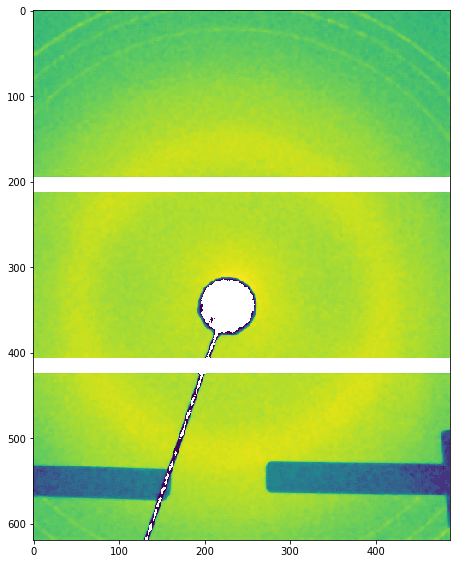

1048575


In [7]:
row_maxtsi = df.loc[df.tsi.idxmax()]
print row_maxtsi
print row_maxtsi.imagename
imagedata = get_imagedata(row_maxtsi.imagename)
show_cbf(imagedata)
plt.show()
print imagedata.max()

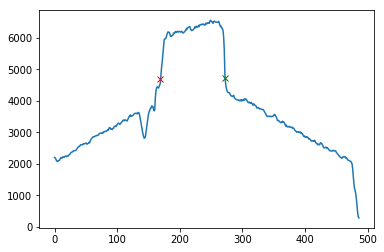

In [8]:
imagedata_shadow = ndimage.median_filter(imagedata[500:600,:], size=5)
# imagedata_shadow = imagedata[500:600,:]

# left = 100 + get_shadow_position(imagedata_shadow[:, 100:250])
# right = 250 + get_shadow_position(imagedata_shadow[:, 250:400])
left = np.sum(imagedata_shadow[:, 100:250], axis=0)
lefty = np.average([left.min(), left.max()])
right = np.sum(imagedata_shadow[:, 200:400], axis=0)
righty = np.average([right.min(), right.max()])
y = np.sum(imagedata_shadow, axis=0)
leftx = 100 + np.argmin(np.abs(left-lefty))
rightx = 200 + np.argmin(np.abs(right-righty))
plt.plot(y)
plt.plot(leftx, lefty, 'rx')
plt.plot(rightx, righty, 'gx')




[ 5 11  7  9  9  4 17  3  9  7 10 20  6  6  2  1  0  1  0  1  0  0  0  0
  0  0  0  1  0  0  0  1  0  1  4  3]
[2870 2970 3070 3170 3270 3370 3470 3570 3670 3770 3870 3970 4070 4170
 4270 4370 4470 4570 4670 4770 4870 4970 5070 5170 5270 5370 5470 5570
 5670 5770 5870 5970 6070 6170 6270 6370 6470]


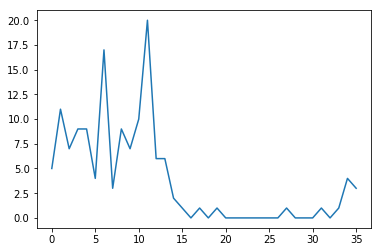

In [9]:
y = np.sum(imagedata_shadow[:, 250:400], axis=0)
# plt.plot(y)
bins = np.arange(y.min(), y.max(), 100)
hist, bins = np.histogram(y, bins=bins)
print hist
print bins
plt.plot(hist)
# plt.hist(hist, bins=bins)

In [10]:
# exploring left shadow position
# ideally one would use the distance between the shadows as a measure for the strain
# but the left shadow interferes with the shadow from the beamstop, so the left shadow position cannot be determined precisely
# => don't use left shadow
# in principle the right shadow alone would be enough to determine the current nominal strain
# but the shadow moves not only due to strain but also due to scanning
# so one has to compensate for the scanning movement
# print df.head()
# df2 = df[:1000]
# print df2.tail()
# print len(df2)
# df2['left_shadow_position'] = df2.imagename.apply(get_left_shadow_position)

### Compute position of right shadow (in pixels)

In [11]:
df['right_shadow_position'] = df.imagename.apply(get_right_shadow_position)
print df.head()

                         imagename  image_scanrow  image_scancol  \
0  nr8low_dyn_1_00008r10_00001.cbf             10              0   
1  nr8low_dyn_1_00008r10_00002.cbf             10              0   
2  nr8low_dyn_1_00008r10_00003.cbf             10              0   
3  nr8low_dyn_1_00008r10_00004.cbf             10              0   
4  nr8low_dyn_1_00008r10_00005.cbf             10              0   

                 datetime       tsi  right_shadow_position  
0 2012-11-28 06:57:23.240  13149531                    273  
1 2012-11-28 06:57:23.260  13236448                    271  
2 2012-11-28 06:57:23.280  13361030                    268  
3 2012-11-28 06:57:23.300  13490809                    266  
4 2012-11-28 06:57:23.320  13541919                    263  


In [12]:
# df2['shadow_distance'] = df2['right_shadow_position'] - df2['left_shadow_position']
# print df2.head()
# turns out to be imprecise due to difficulties to determine left shadow position
# so strain is computed based only on right shadow, 
# but this is fine as long as corrections are made to compensate for the motion of the shadow due to scanning

### Find scan position in mm

In [13]:
df['image_scanrow_mm'] = df.image_scanrow.apply(lambda x: float(x)*scan_stepsize)
df['image_scancol_mm'] = df.image_scancol.apply(lambda x: float(x)*scan_stepsize)
# print df.head()

### Find shadow position in mm

In [14]:
df['right_shadow_position_mm'] = df.right_shadow_position.apply(lambda x: float(x)*pixelsize)
# print df.head()

### Correct shadow position for scan motion

nr8low_dyn_1_00008r1_00481.cbf


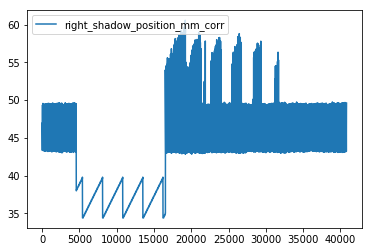

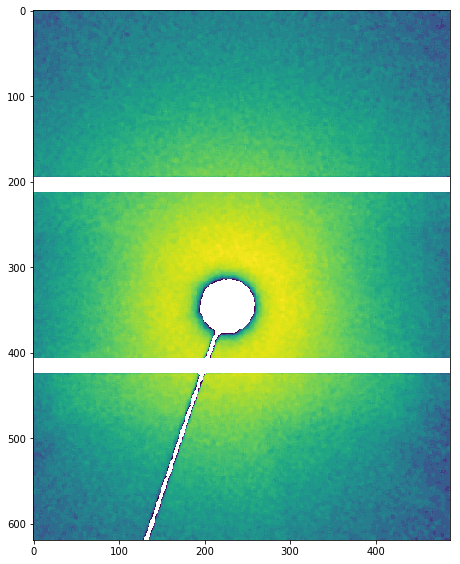

In [15]:
df['right_shadow_position_mm_corr'] = df.right_shadow_position_mm + 2.*df.image_scancol_mm
# print df.head()
df[:].plot(y='right_shadow_position_mm_corr')
imagedata = get_imagedata(df.imagename[17015])
print df.imagename[17015]
show_cbf(imagedata)
# df.plot(y='image_scancol_mm')

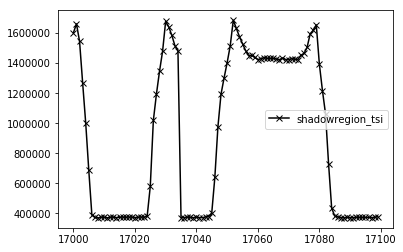

In [16]:
df['shadowregion_tsi'] = df.imagename.apply(shadowregion_tsi)
df[17000:17100].plot(y='shadowregion_tsi', style='kx-')
# show_cbf(get_imagedata(df.imagename[17060]))

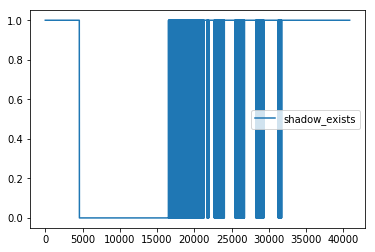

In [17]:
# all the same:
# df['shadow_exists'] = df.shadowregion_tsi.apply(lambda x: np.where(x>1e6, 1, 0))
# df.head()
# df['shadow_exists'] = np.where(df.shadowregion_tsi>1e6, 1, 0)
# df.head()
df['shadow_exists'] = (df.shadowregion_tsi>1e6).astype(int)
# df.head()
df.plot(y='shadow_exists')

### Mask out invalid images (too low tsi, no shadow)

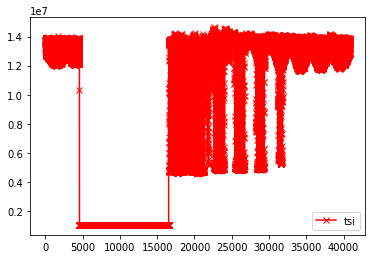

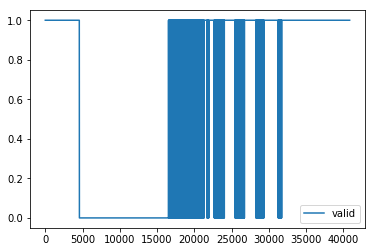

In [18]:
df.plot(y='tsi', style='r-x')
df['valid'] = (((df.tsi > .2e7) & df.shadow_exists) | (df.image_scanrow == 6)).astype(int)
df['valid'] = ((df.tsi > .2e7) & df.shadow_exists).astype(int)
df.plot(y='valid')
# show_cbf(get_imagedata(df.imagename[10000]))
# print df[5000:5050]
# print df.tail()

### Convert shadow position to nominal strain

42.868
49.76
25152


C:\Anaconda2\envs\py2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


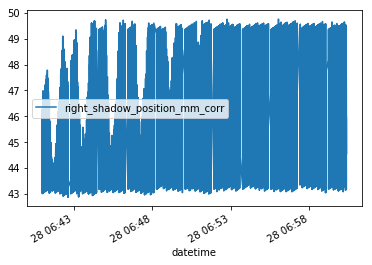

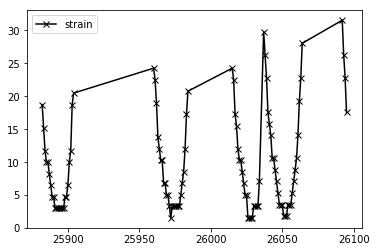

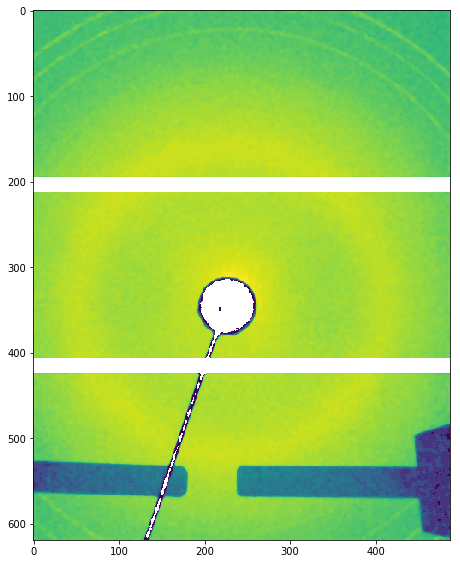

In [19]:
%matplotlib inline
df[df.valid==1].plot(x='datetime', y='right_shadow_position_mm_corr')
print df.right_shadow_position_mm_corr[df.valid==1].min()
print df.right_shadow_position_mm_corr[df.valid==1].max()
print len(df[df.valid==1])
# create new dataframe with only valid diffraction images
df2 = df[df.valid==1]
df2['strain'] = shadow2strain(df2.right_shadow_position_mm_corr)
df2[11000:11100].plot(y='strain', style='k-x')
show_cbf(get_imagedata(df.imagename.loc[25900]))

### Assign strain gradient (loading or unloading)

In [20]:
# fumbling around with more complex determination of strain gradient 
# to avoid artefacts introduced from scanning or invalid shadows
# but this should do just fine, 
# as a few wrong values don't affect the median as long as there are enough values close to the median
df2['strain_gradient'] = np.sign(np.gradient(df2.strain)).astype(int)
# df2.head()
# df2.tail()


C:\Anaconda2\envs\py2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Explore method for degree of crystallinity computation from peak intensity

Int64Index([34076, 34077, 34078, 34079, 34080, 34081, 34082, 34083, 34084,
            34130, 34131, 34132, 34133],
           dtype='int64')


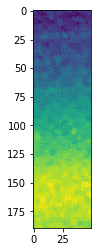

[25 26 27 28 29 30 70 71 72 73 74 75]


0.1858322838397173


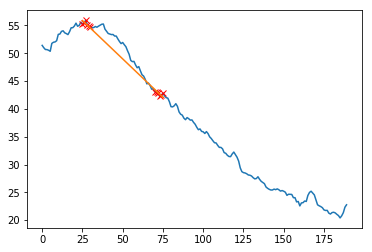

0.196001197691551


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
# find an image with high crystallinity, i.e. large strain and located at the crack tip:
indices = df2.index[(df2.image_scanrow == 7) & (df2.image_scancol == 13) & (df2.strain > 62)]
# df.image_scanrow = df.image_scanrow.astype(int)
# df.image_scancol = df.image_scancol.astype(int)
# indices = df.index[(df.image_scanrow == 6)& (df.image_scancol == 13)]
# print df
print indices

# for idx in indices: # show those images that are under high strain at the crack tip
# #     print df2.imagename[idx], df2.strain[idx]
#     print idx, df.imagename[idx]
#     show_cbf(get_imagedata(df.imagename[idx])[0:200,:])
#     plt.show()
imagedata = get_imagedata(df.imagename[34082])
# show_cbf(imagedata)
imagedata = ndimage.median_filter(imagedata[:190,200:250], size=5)
# imagedata = imagedata[:190,200:250]
plt.imshow(np.log(imagedata))
plt.show()
y = np.average(imagedata,axis=1)[::-1]
plt.plot(y)
x1 = np.arange(25, 31)
x2 = np.arange(70, 76)
x3 = np.concatenate((x1, x2))
print x3
y3 = y[x3]
plt.plot(x3, y3, 'rx')
from lmfit.models import LinearModel
mod = LinearModel()
out = mod.fit(y3,x=x3)
xfit = np.arange(25,76)
yfit = out.eval(x=xfit)
plt.plot(xfit, yfit)
doc = np.sum(y[25:76]-yfit)/np.sum(y[25:31])
print doc
plt.show()
doc = get_doc(df.imagename[34082])
print doc


### Apply crystallinity calculation to all valid images

In [22]:
df2['doc'] = df2.imagename.apply(get_doc)


C:\Anaconda2\envs\py2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Compute crystallinity map

C:\Anaconda2\envs\py2\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


1
max doc:  0.6905152951983821
min doc:  -0.14656597380930578
strain between  0.0  and  14.0  strain gradient  1
max. DOC at this strain:  0.5


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

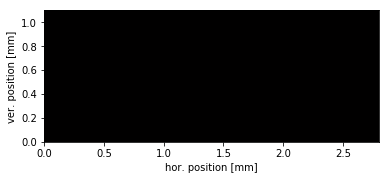

strain between  14.0  and  28.0  strain gradient  1
max. DOC at this strain:  0.600272688624906


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

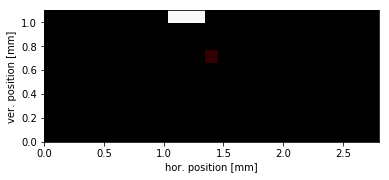

strain between  28.0  and  42.0  strain gradient  1
max. DOC at this strain:  0.7289833630567921


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

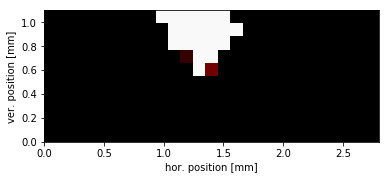

strain between  42.0  and  56.0  strain gradient  1
max. DOC at this strain:  0.898907641521935


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

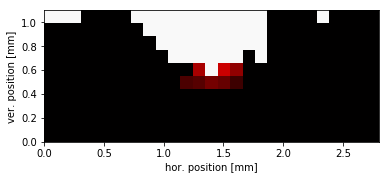

strain between  56.0  and  70.0  strain gradient  1
max. DOC at this strain:  0.9936979062725955


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

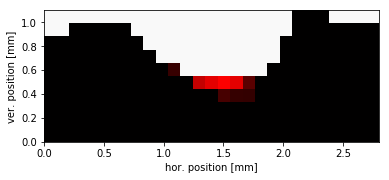

strain between  56.0  and  70.0  strain gradient  -1
max. DOC at this strain:  0.9301630281418278


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

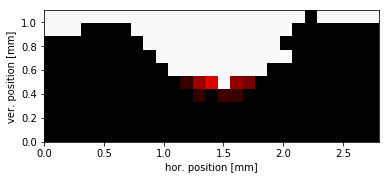

strain between  42.0  and  56.0  strain gradient  -1
max. DOC at this strain:  0.7266835470465581


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

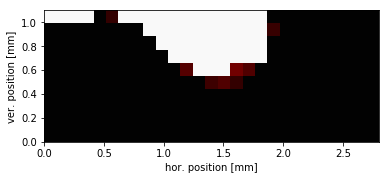

strain between  28.0  and  42.0  strain gradient  -1
max. DOC at this strain:  0.5


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

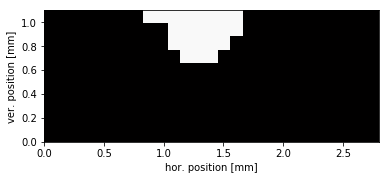

strain between  14.0  and  28.0  strain gradient  -1
max. DOC at this strain:  0.5


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

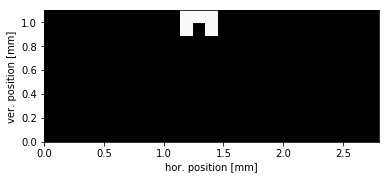

strain between  0.0  and  14.0  strain gradient  -1
max. DOC at this strain:  0.5


Text(0.5,0,u'hor. position [mm]')

Text(0,0.5,u'ver. position [mm]')

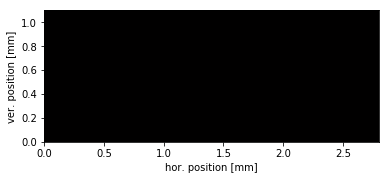

In [23]:
%matplotlib inline
import matplotlib
df2.image_scanrow = df2.image_scanrow.astype(int)
df2.image_scancol = df2.image_scancol.astype(int)
row_max = df2.image_scanrow.max()
row_min = df2.image_scanrow.min()
col_max = df2.image_scancol.max()
col_min = df2.image_scancol.min()
print row_min
n_rows = row_max - row_min + 1
n_cols = col_max - col_min + 1
doc_max = df2.doc.max()
print 'max doc: ', doc_max
doc_min = df2.doc.min()
print 'min doc: ', doc_min
m1 = np.zeros((n_rows-1, n_cols-1)) # cut off last row and last col as scan was interrupted during last row and nothing happens in last col
strain_levels = np.linspace(0, amplitude, strain_steps)
# print strain_levels
extent = np.array([0,n_cols, 0, n_rows])*scan_stepsize
n = 0
for not_strain_gradient in [-1, 1]:
    strain_steps_array = range(strain_steps-1)
    if not_strain_gradient == 1: strain_steps_array = strain_steps_array[::-1] # descending strain for unloading branch
    for i in strain_steps_array:
        print 'strain between ', strain_levels[i], ' and ', strain_levels[i+1], ' strain gradient ', str(-1*not_strain_gradient)
        temp = df2[(df2.strain >= strain_levels[i]) & (df2.strain < strain_levels[i+1]) & (df2.strain_gradient != not_strain_gradient)] # loading only
        for y in range(n_rows-1):
            for x in range(n_cols-1):
                temp2 = temp[(temp.image_scanrow == y + row_min) & (temp.image_scancol == x + col_min)]
#                 m1[y,x] = temp2.tsi.mean()
                if len(temp2) > 0:
                    doc = temp2.doc.median()
                    if doc < .2*doc_max: m1[y,x] = .5 # threshold for DOC to be displayed, smaller values are assumed to be due to noise
                    else: m1[y,x] = (doc/doc_max)*.5+.5 # scaling DOC from .5 (DOC = 0) to 1 (DOC = doc_max)
                    # keep m1 at 0 otherwise (if pixel is invalid)
                    # for efficiency, this kind of mapping colors could be done at array level later
#                 print 'number of images at this scan point: ', len(temp2)
        print 'max. DOC at this strain: ', m1.max()
#       print 'max. DOC at this strain: ', m1[1:,:-1].max()
#         print type(m1)
        plt.imshow(m1, vmin = .0, vmax = 1., cmap = doc_cmap, extent=extent)
        plt.xlabel('hor. position [mm]')
        plt.ylabel('ver. position [mm]')
        plt.savefig(make_png_name(n), bbox_inches='tight')
        plt.show()
        n += 1
        m1[:,:] = .0



### Turn series of png's into animated gif

In [24]:
from moviepy import editor as mpy

pngs = glob.glob(os.path.join(output_path, '*.png'))
fps = frequency*len(pngs)
clip = mpy.ImageSequenceClip(pngs, fps=fps)
clip.write_gif(os.path.join(output_path, 'docmap.gif'), fps=fps)


[MoviePy] Building file F:\beamlinedata\DESY\results\docmap.gif with imageio


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 70.42it/s]
